In [27]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

GC_WINDOW_SIZE = 1000000

# based on: 
# experiments/germline-model/chen-et-al-2022/compare-mchale-and-chen-windows.ipynb
# experiments/germline-model/chen-et-al-2022/null-distribution-is-normal.ipynb
# experiments/germline-model/chen-et-al-2022/QQ-plot-for-noncoding-windows.ipynb

## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [3]:
import pandas as pd
from functools import reduce
import numpy as np 

def compute_N_mean_null_gnocchi(row): 
    a = 1 
    b = -(2*row['N_observed'] + row['gnocchi']**2)
    c = row['N_observed']**2
    sqrt = np.sqrt(b**2 - 4*a*c)
    sign = 1 if row['gnocchi'] > 0 else -1
    return (-b + sign*sqrt)/(2*a)    

def get_windows_with_GC_content_and_cpg_islands(): 
  df1 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.B.paternal_recombination_rate.maternal_recombination_rate.gBGC-tract-counts.non-exonic.gBGC.bed', 
    sep='\t', 
  )
  df1 = df1.drop(columns=['N_expected']) 

  for gc_window_size in [
    1000, 
    10000, 
    100000,
    1000000,
  ]:
    df_temp = pd.read_csv(
      f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.GC_content_{gc_window_size}.bed', 
      sep='\t', 
    )
    df_temp = df_temp[['chen_chrom', 'chen_start', 'chen_end', 'window_GC_content']]
    df_temp = df_temp.rename(columns={
      'chen_chrom': 'chrom', 
      'chen_start': 'start', 
      'chen_end': 'end',
      'window_GC_content': f'GC_content_{gc_window_size}bp'
    })
    df1 = pd.merge(df1, df_temp, on=['chrom', 'start', 'end'], how='inner')

  # created using: experiments/germline-model/chen-et-al-2022/cpg-island-enrichment.ipynb
  df2 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon-cpgIsland.bed',
    sep='\t', 
  )
  df2 = df2[['chromosome', 'start', 'end', 'cpg_island overlap', 'window overlaps cpg_island']]
  df2 = df2.rename(columns={
    'chromosome': 'chrom', 
    'cpg_island overlap': 'cpg_island_overlap', 
    'window overlaps cpg_island': 'window_overlaps_cpg_island'
  })

  dfs = [df1, df2]
  df = reduce(lambda left, right: pd.merge(left, right, on=['chrom', 'start', 'end'], how='inner'), dfs)

  df['N_mean_null_gnocchi'] = df.apply(compute_N_mean_null_gnocchi, axis=1)

  return df

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi
0,chr1,1432000,1433000,4.299894,259,True,False,0.653,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False,338.059552
1,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657
2,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925
3,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243
4,chr1,1463000,1464000,2.948188,191,True,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False,236.321790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,302,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True,263.131293
1019147,chr9,137268000,137269000,3.640544,212,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False,272.046527
1019148,chr9,137269000,137270000,5.276351,209,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False,300.458958
1019149,chr9,137275000,137276000,2.687348,290,True,False,0.536,1.564889,0.024254,...,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False,339.517045


## Central Limit Theorem (CLT) predicts that z-scores should be standard-normal distributed

The number of distinct ALT alleles $N_i$ at a site $i$ is a categorical variable with site-dependent mean $\langle N_i \rangle$ and variance $\text{var} (N_i)$. (See [model](https://github.com/quinlan-lab/constraint-tools/blob/main/define-model/germline-model.ipynb).) Since these random variables are independent, but not identically distributed, the [Lyapunov CLT](https://en.wikipedia.org/wiki/Central_limit_theorem#Lyapunov_CLT) applies. This theorm states that, if the number of sites $l$ in a window is large enough (we consider $l=1000$), then $N = \sum_i N_i$ is distributed as: 

\begin{equation}
\frac{N - \langle N \rangle}{\sqrt{\text{var}(N)}} \sim \text{Normal}(0, 1) 
\end{equation}

where 

$$ 
\langle N \rangle = \sum_i \langle N_i \rangle 
$$ 

and 

$$ 
\text{var}(N) = \sum_i \text{var}(N_i).
$$


If one simulates many windows, and generates a single SNV count for each window, then the distribution of z-scores of those windows will be a standard normal. 




## The distribution of Gnocchi is over-dispersed, and the over-dispersion correlates with GC content, gBGC and BGS

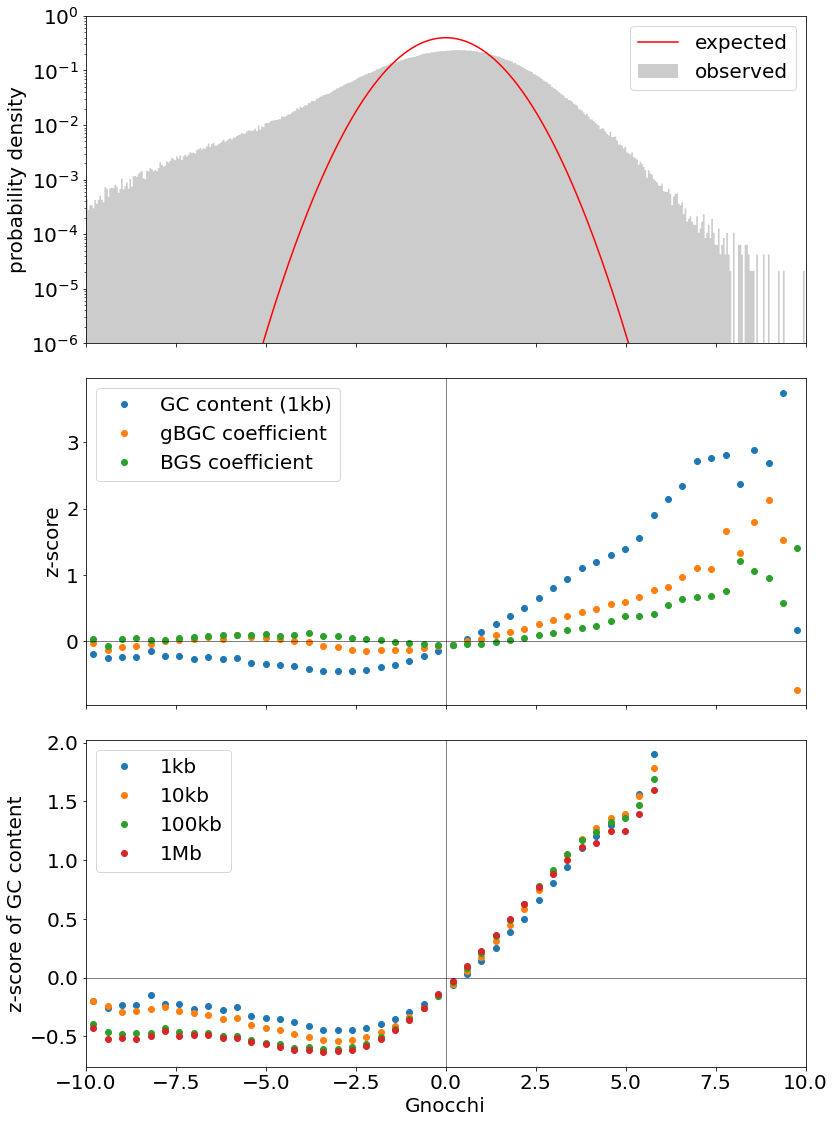

In [21]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})

from scipy.stats import norm

def length_to_string(length): 
    if length < 1000: 
        return f'{length}bp'
    elif length < 1000000: 
        return f'{int(length/1000)}kb'
    else: 
        return f'{int(length/1000000)}Mb'
    
def plot_feature_zscore_vs_gnocchi(df, feature, label, ax, gnocchi_max=None):
    df = df.copy()

    zscore_feature_name = f'zscore_{feature}'
    df[zscore_feature_name] = (df[feature] - df[feature].mean())/df[feature].std()

    df['gnocchi_binned'] = pd.cut(df['gnocchi'], bins=50)
    df_aggregated = df.groupby('gnocchi_binned')[zscore_feature_name].mean()
    df_aggregated.index = df_aggregated.index.map(lambda x: x.mid)

    if gnocchi_max: 
        df_aggregated = df_aggregated[np.array(df_aggregated.index) < gnocchi_max]
        ax.plot(df_aggregated.index, df_aggregated, marker='o', linestyle='', label=label)
    else: 
        ax.plot(df_aggregated.index, df_aggregated, marker='o', linestyle='', label=label)

def plot_distribution_of_gnocchi_and_other_features(df): 
    fig, axs = plt.subplots(3, 1, figsize=(12, 16), sharex=True)

    _, bins, _ = axs[0].hist(
        df['gnocchi'], 
        density=True, 
        bins='auto', 
        histtype='stepfilled', 
        alpha=0.2, 
        label='observed', 
        color='black'
    )
    axs[0].plot(bins, norm.pdf(bins), label='expected', color='red')
    axs[0].set_ylabel('probability density')
    axs[0].set_xlim([-10, 10])
    axs[0].set_yscale('log')
    axs[0].set_ylim([1e-6, 1])
    axs[0].legend()

    gc_window_size = 1000
    plot_feature_zscore_vs_gnocchi(
        df, 
        feature=f'GC_content_{gc_window_size}bp', 
        label=f'GC content ({length_to_string(gc_window_size)})', 
        ax=axs[1]
    )
    plot_feature_zscore_vs_gnocchi(
        df, 
        feature='B_M1star.EUR',
        label='gBGC coefficient', 
        ax=axs[1]
    )
    plot_feature_zscore_vs_gnocchi(
        df, 
        feature='B',
        label='BGS coefficient', 
        ax=axs[1]
    )
    axs[1].axhline(0, color='black', linewidth=0.5)
    axs[1].axvline(0, color='black', linewidth=0.5)        
    axs[1].set_ylabel('z-score')
    axs[1].legend()

    for gc_window_size in [1000, 10000, 100000, 1000000]:
        plot_feature_zscore_vs_gnocchi(
            df, 
            feature=f'GC_content_{gc_window_size}bp', 
            label=f'{length_to_string(gc_window_size)}', 
            ax=axs[2],
            gnocchi_max=6
        )
    axs[2].axhline(0, color='black', linewidth=0.5)
    axs[2].axvline(0, color='black', linewidth=0.5)        
    axs[2].set_xlabel('Gnocchi')
    axs[2].set_ylabel('z-score of GC content')
    axs[2].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_distribution_of_gnocchi_and_other_features(WINDOWS)

## p-values are massively inflated, and correlate with GC content, gBGC and BGS

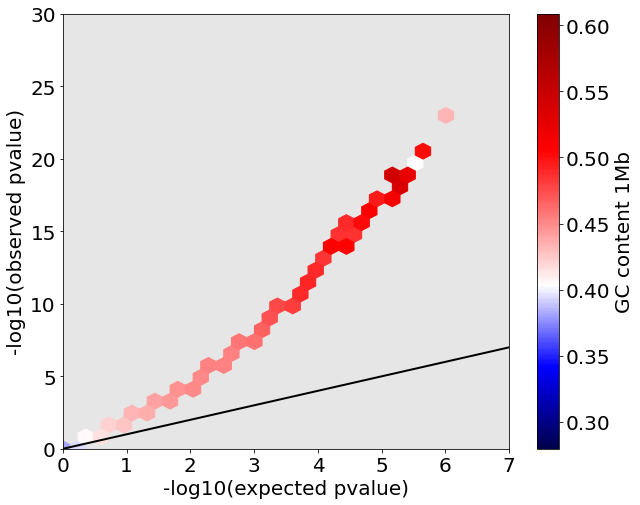

In [28]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm

def compute_sorted_pvalues_gnocchi(df, feature_str, tail='left'): 
    N_observed, theta_mean, feature = (
        df['N_observed'],
        df['N_mean_null_gnocchi'], 
        df[feature_str]
    )
    theta_variance = theta_mean # assume Poisson 
    # use CLT to compute p-values: 
    if tail == 'left': 
        p_values = norm.cdf(N_observed, loc=theta_mean, scale=np.sqrt(theta_variance))
    elif tail == 'right': 
        p_values = 1 - norm.cdf(N_observed, loc=theta_mean, scale=np.sqrt(theta_variance))
    else: 
        raise ValueError(f'tail must be either "left" or "right" but got {tail}')

    # Get the indices that would sort p_values
    sort_indices = np.argsort(p_values)

    # Rearrange both p_values and feature
    p_values = p_values[sort_indices]
    feature = feature[sort_indices]

    return p_values, feature

def plot_order_statistics(df, feature_str, label, tail='left', xlim=[0, 7], ylim=[0, 30]): 
    p_values, feature = compute_sorted_pvalues_gnocchi(df, feature_str, tail)

    # https://github.com/petermchale/QQ-plots/blob/master/qq-plots.pdf
    observed_order_statistics = p_values
    expected_order_statistics = [(i+1)/(len(df)+1) for i in range(len(df))]    

    # Create a diverging colormap
    cmap = cm.get_cmap('seismic')  # Use cm.get_cmap instead of plt.get_cmap
    divnorm = TwoSlopeNorm(vmin=feature.min(), vcenter=feature.mean(), vmax=feature.max())

    plt.figure(figsize=(10, 8))
    # Create a hexbin plot with bins colored by the mean value of feature
    hb = plt.hexbin(
        -np.log10(expected_order_statistics), 
        -np.log10(observed_order_statistics), 
        C=feature, 
        gridsize=25, 
        reduce_C_function=np.mean,
        cmap=cmap,
        norm=divnorm,
    )
    plt.gca().set_facecolor(3*[0.9])  # Set the background color of the axis to a lighter shade of grey
    plt.colorbar(hb, label=label)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(xlim, xlim, 'k-', linewidth=2)
    plt.xlabel('-log10(expected pvalue)')
    plt.ylabel('-log10(observed pvalue)')

plot_order_statistics(
    WINDOWS,
    feature_str=f'GC_content_{GC_WINDOW_SIZE}bp', 
    label=f'GC content {length_to_string(GC_WINDOW_SIZE)}', 
    tail='left'
)    

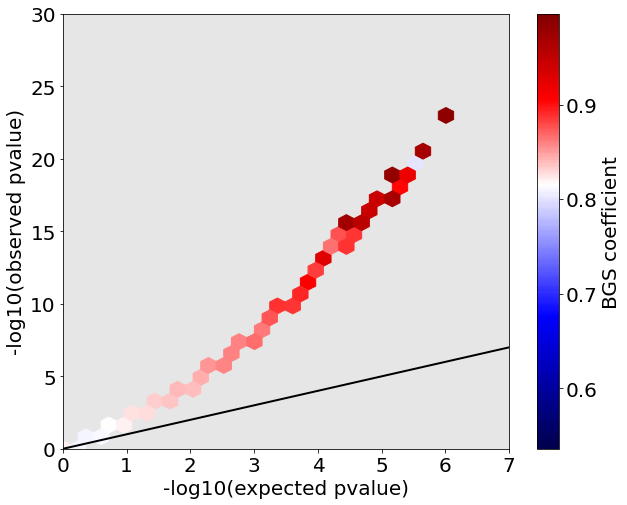

In [24]:
plot_order_statistics(
    WINDOWS, 
    feature_str='B', 
    label=f'BGS coefficient',
    tail='left'
)

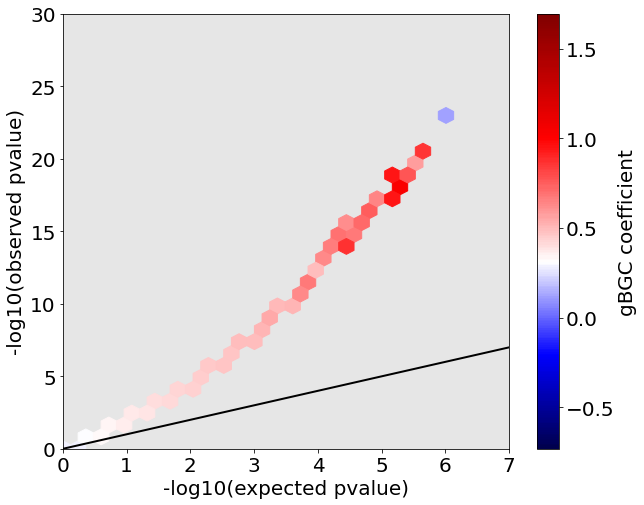

In [25]:
plot_order_statistics(
    WINDOWS, 
    feature_str='B_M1star.EUR', 
    label=f'gBGC coefficient',
    tail='left'
)

## GC content, gBGC and BGS are correlated 


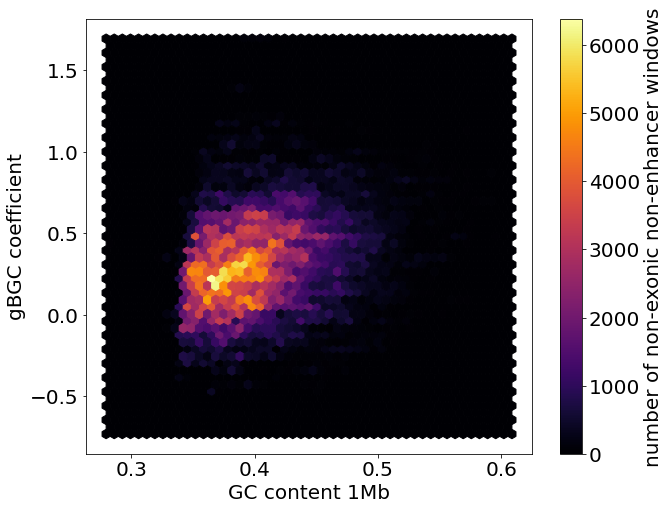

In [33]:
def window_count_heat_map(df, x, y, xlabel, ylabel, min_windows=0):
  plt.figure(figsize=(10, 8))  

  plt.hexbin(
    df[x], 
    df[y], 
    gridsize=50, 
    cmap='inferno',
    mincnt=min_windows  # Minimum number of windows required for a hexbin to be displayed
  )

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.colorbar(label='number of non-exonic non-enhancer windows')

window_count_heat_map(
  WINDOWS, 
  x=f'GC_content_{GC_WINDOW_SIZE}bp', 
  y='B_M1star.EUR', 
  xlabel=f'GC content {length_to_string(GC_WINDOW_SIZE)}', 
  ylabel='gBGC coefficient'
)

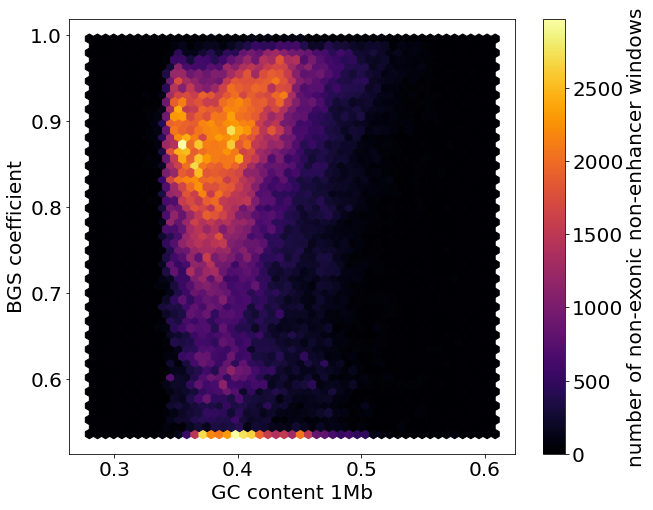

In [34]:
window_count_heat_map(
  WINDOWS, 
  x=f'GC_content_{GC_WINDOW_SIZE}bp', 
  y='B', 
  xlabel=f'GC content {length_to_string(GC_WINDOW_SIZE)}', 
  ylabel='BGS coefficient'
)

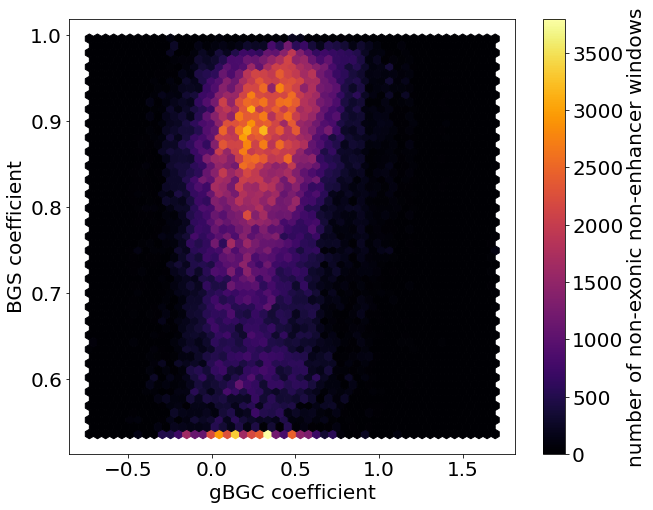

In [35]:
window_count_heat_map(
  WINDOWS, 
  x='B_M1star.EUR', 
  y='B', 
  xlabel='gBGC coefficient', 
  ylabel='BGS coefficient'
)

In [ ]:
# TODO: 
# condition on two (confounding) feature z-scores (e.g., z between -1 and 1), and plot zscore of other feature as a function of gnocchi ! 
# when we do this for BGS, we should find a trend opposite to the marginal trend ! 